## Семинар 2 "Распознавание рукописных цифр"

ФИО: Усцов Артем Алексеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [49]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from tqdm import tqdm
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

In [9]:
print(f"{X.shape=}", f"{y.shape=}")

X.shape=(32, 784) y.shape=(32,)


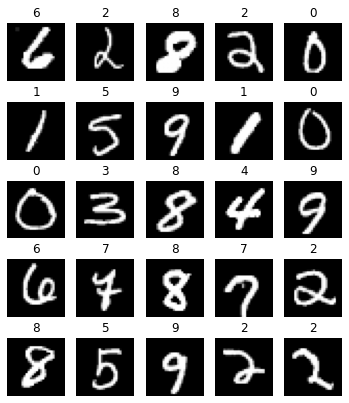

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [11]:
def train(network, train_loader, test_loader, epochs, learning_rate, plot=True, 
          verbose=True, loss=NLLLoss()):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    __token = True
    try:
        
        for epoch in tqdm(range(epochs)): # цикл по эпохам
            losses = []
            accuracies = []
            
            # обучаемся на каждом объекте из трейн-датасета
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)

                if __token: # Технический вывод, чтобы узнать, как ведут себя данные
                    print(f"Массив предсказаний\n {prediction[0]}\n")
                    print(f"Предсказанная метка: {np.argmax(prediction[0])}")
                    print(f"Фактическая метка: {y[0]}\n")
                    __token = False

                accuracies.append((np.argmax(prediction, axis=1)==y).mean())

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []

            # обучаемся на каждом объекте из тестового-датасета
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, axis=1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))

            clear_output(wait=True) # для динамического обновления графиков, wait - очищает вывод

            if verbose: # детализация выводимой информации
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch+1, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    
            if plot:
                plt.figure(figsize=(12, 5))
                
                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    
    except KeyboardInterrupt as KI:
        print(KI)

    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [12]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 10... (Train/Test) NLL: 0.761/0.678	Accuracy: 0.786/0.818

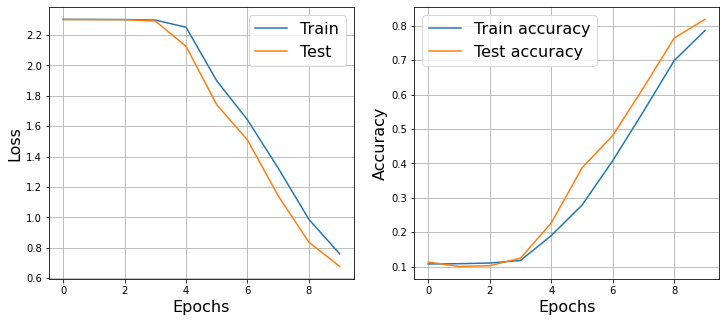

100%|███████████████████████████████████████████| 10/10 [06:18<00:00, 37.89s/it]


In [13]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network,train_loader, test_loader, 10, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [14]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = self.X > 0
        return dydX * dLdy

    def step(self, learning_rate):
        pass

In [15]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Модель с ReLU

Epoch 10... (Train/Test) NLL: 0.088/0.102	Accuracy: 0.975/0.971

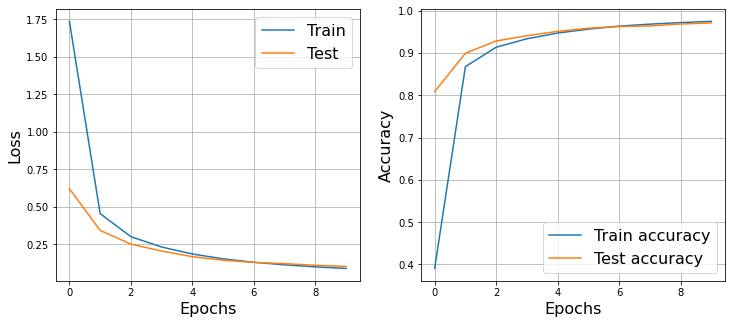

100%|███████████████████████████████████████████| 10/10 [07:16<00:00, 43.65s/it]


In [16]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network,train_loader, test_loader, 10, 0.01, plot=True, verbose=True)

Модель с ELU

Epoch 10... (Train/Test) NLL: 0.103/0.110	Accuracy: 0.970/0.965

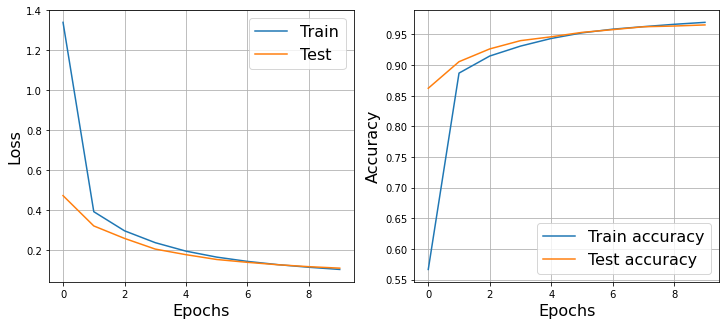

100%|███████████████████████████████████████████| 10/10 [05:38<00:00, 33.89s/it]


In [17]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network,train_loader, test_loader, 10, 0.01, plot=True, verbose=True)

Рассмотрим динамику ошибки и accuracy на всех активационных функциях

In [18]:
def compare_activation_func(loss_results: list, acc_results: list, labels: list) -> None:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    for loss_result, label in zip(loss_results, labels):
        plt.plot(loss_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    for acc_result, label in zip(acc_results, labels):
        plt.plot(acc_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.show()

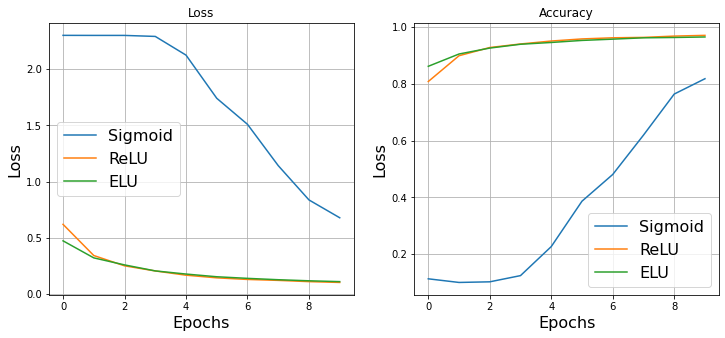

In [19]:
compare_activation_func(loss_results=[ts_s, ts_r, ts_e], acc_results=[ts_ac_s, ts_ac_r, ts_ac_e],
                       labels=["Sigmoid", "ReLU", "ELU"])

### HW1 (1 балл): Реализовать Tanh

In [20]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return (2. / (1 + np.exp(-2 * X))) - 1.

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 4 / ((np.exp(self.X) + np.exp(-self.X)) ** 2)
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Epoch 10... (Train/Test) NLL: 0.083/0.098	Accuracy: 0.978/0.972

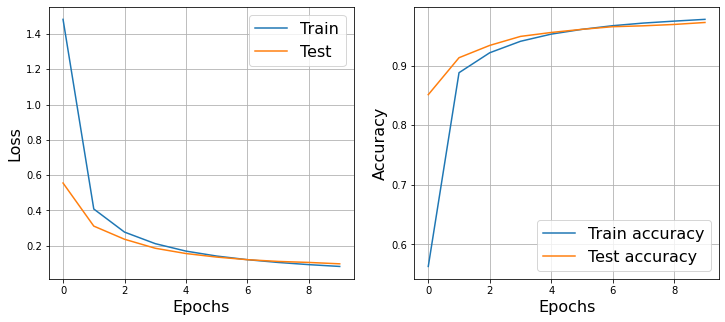

100%|███████████████████████████████████████████| 10/10 [05:36<00:00, 33.65s/it]


In [21]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_th, ts_th, tr_ac_th, ts_ac_th = train(network, train_loader, test_loader, 10, 0.01, plot=True, verbose=True)

Сравним все 4-е активационные функции на нашем датасете 

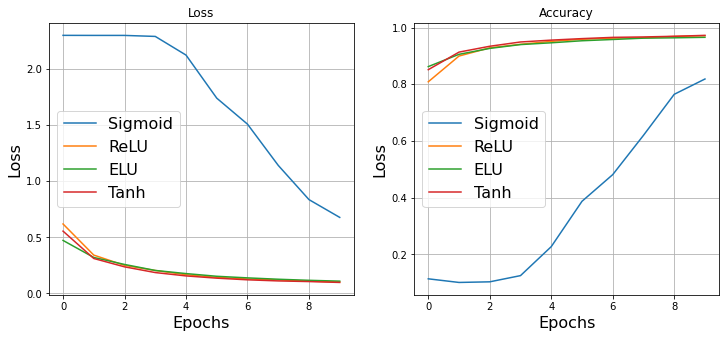

In [22]:
compare_activation_func(loss_results=[ts_s, ts_r, ts_e, ts_th], 
                        acc_results=[ts_ac_s, ts_ac_r, ts_ac_e, ts_ac_th],
                        labels=["Sigmoid", "ReLU", "ELU", "Tanh"])

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [34]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    
    prediction = network.forward(X)
    # Softmax трансформация данных
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])

In [42]:
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

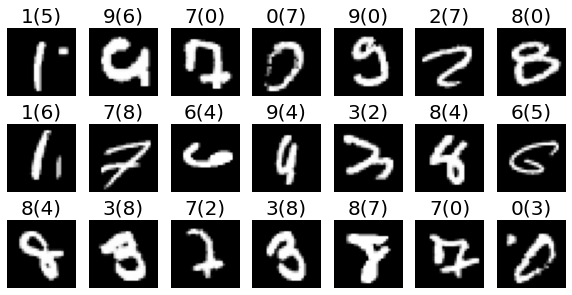

In [26]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

Налицо проблемы с определением 1, 7, 3 и 8

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [53]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])

Аугментация вращением рандомного элемента

Epoch 10... (Train/Test) NLL: 0.129/0.100	Accuracy: 0.961/0.971

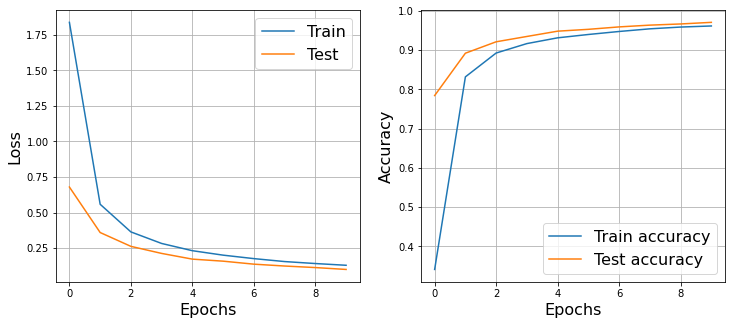

100%|███████████████████████████████████████████| 10/10 [08:56<00:00, 53.61s/it]


In [46]:
# !pip install scikit-image
from skimage.transform import rotate
degrees = 15
transform_rotation = transforms.Compose([
                     transforms.RandomRotation(degrees),
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307,), (0.3081,))
                   ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_rotation)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

network = NeuralNetwork([Linear(784, 100), ReLU(),
           Linear(100, 100), ReLU(),
           Linear(100, 10)])

tr_l_r, t_l_r, tr_a_r, t_a_r = train(network, train_loader, test_loader, 10, 0.01)

Аугментация рандомным сдвигом, без поворота

Epoch 10... (Train/Test) NLL: 0.125/0.091	Accuracy: 0.962/0.972

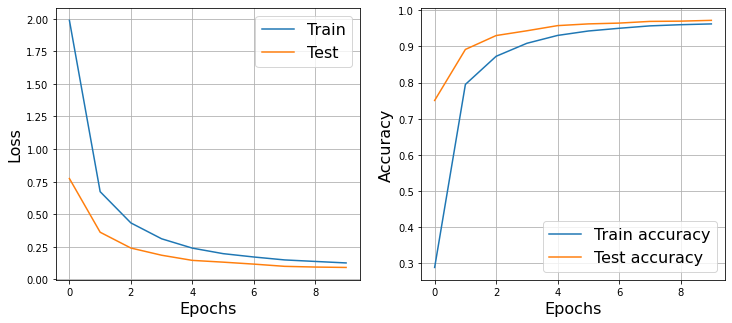

100%|███████████████████████████████████████████| 10/10 [08:20<00:00, 50.01s/it]


In [47]:
transform_tr = transforms.Compose([
                   transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_tr)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([Linear(784, 100), ReLU(),
           Linear(100, 100), ReLU(),
           Linear(100, 10)])

tr_l_a, t_l_a, tr_a_a, t_a_a = train(network, train_loader, test_loader, 10, 0.01)

Аугментация нормально распределенным шумом

Epoch 10... (Train/Test) NLL: 0.576/0.199	Accuracy: 0.806/0.951

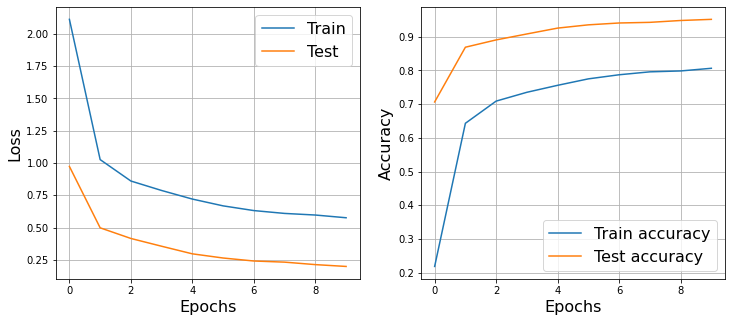

100%|███████████████████████████████████████████| 10/10 [05:55<00:00, 35.59s/it]


In [50]:
transform_tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_tr)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([Linear(784, 100), ReLU(),
           Linear(100, 100), ReLU(),
           Linear(100, 10)])

tr_l_n, t_l_n, tr_a_n, t_a_n = train(network, train_loader, test_loader, 10, 0.01)

Аугментация с вращением, афинными преобразованиями и добавлением нормально распределенного шума

Epoch 10... (Train/Test) NLL: 1.081/0.331	Accuracy: 0.631/0.934

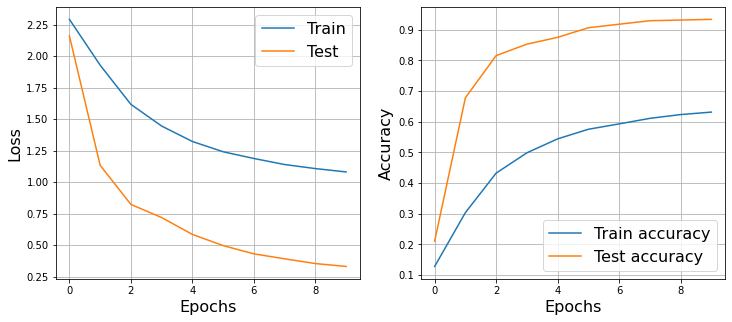

100%|███████████████████████████████████████████| 10/10 [08:31<00:00, 51.14s/it]


In [51]:
transform_tr = transforms.Compose([
    transforms.RandomAffine(15, (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_tr)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([Linear(784, 100), ReLU(),
           Linear(100, 100), ReLU(),
           Linear(100, 10)])

tr_l_all, t_l_all, tr_a_all, t_a_all = train(network, train_loader, test_loader, 10, 0.01)

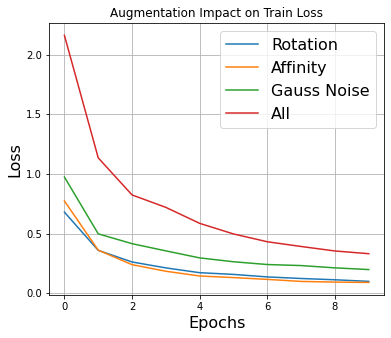

In [52]:
plt.figure(figsize=(6, 5))
plt.title('Augmentation Impact on Train Loss')


plt.plot(t_l_r, label='Rotation')
plt.plot(t_l_a, label='Affinity')
plt.plot(t_l_n, label='Gauss Noise')
plt.plot(t_l_all, label='All')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

- __Нелинейности:__  
Tanh быстрее остальных сходится, ReLU и ELU показывают примерно одинаковую скорость сходимости, сигмоида еще медленнее.

Activation Func | Train_Loss   | Test_Loss | Train_Acc | Test_Acc | Learning Time
:---------------|:-----------: |:--------: | :-------: | :------: | :-----------:
Sigmoid         | 0.761        | 0.678     | 0.786     | 0.818    | 6 min 18 sec
ReLU            | 0.088        | 0.102     | 0.975     | 0.971    | 7 min 16 sec
ELU             | 0.103        | 0.110     | 0.970     | 0.965    | 5 min 38 sec
<b>Tanh         | 0.083        | 0.098     | 0.978     | <b>0.972    | <b>5 min 36 sec

- __Предобработка:__  
Случайные сдвиги и повороты даже улучшают качество модели на тестовой выборке, что ожидаемо для данного вида аугментаций.  
Случайный шум существенно ухудшает качество модели, что опять же очевидно.


__Все измерения выполнены на NLLLoss, а также Tanh как функции активации__

Augmentation Type| Train_Loss   | Test_Loss | Train_Acc | Test_Acc | Learning Time
:--------------- |:-----------: |:--------: | :-------: | :------: | :-----------:
Rotation         | 0.129        | 0.100     | 0.961     | 0.971    | 8 min 56 sec
Affinity         | 0.125        | 0.091     | 0.962     | 0.972    | 8 min 20 sec
<b>Gaussian Noise   | 0.576        | 0.199     | <b>0.806     | 0.951    | 5 min 55 sec
<b>All              | 1.081        | 0.331     | <b>0.631     | 0.934    | 8 min 32 sec